In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from util.bilrc_util import read_ns1_data, logtime_r2
from util.fitting import fit_multi_exponential, eval_exp_fit

In [2]:
# Load data from binary files
neg_data = read_ns1_data('data/030722_s1_RTDP_alone_2.ns1')
pyo50_data = read_ns1_data('data/030722_s2_RTDP_50uMPYO_1.ns1')
pyo500_data = read_ns1_data('data/030722_s3_RTDP_500uMPYO_1.ns1')

# list of samples with data resampled to have logarithmically-spaced timepoints
samples = list(zip('0 $\mu$M PYO,50 $\mu$M PYO,500 $\mu$M PYO'.split(','),
                   [neg_data.log_time(), pyo50_data.log_time(), pyo500_data.log_time()]))
for t, s in samples:
    print(s)
    
neg_data.T

<NS1Data excitation=355nm emission=650nm shots=500 points=10000 points_per_second=1000000000.0 fname="data/030722_s1_RTDP_alone_2.ns1"">
<NS1Data excitation=355nm emission=650nm shots=500 points=10000 points_per_second=1000000000.0 fname="data/030722_s2_RTDP_50uMPYO_1.ns1"">
<NS1Data excitation=355nm emission=650nm shots=500 points=10000 points_per_second=1000000000.0 fname="data/030722_s3_RTDP_500uMPYO_1.ns1"">


array([-5.0000000e-07, -4.9899990e-07, -4.9799980e-07, ...,
        9.4979998e-06,  9.4989999e-06,  9.5000000e-06])

In [3]:
pal = sns.color_palette('dark')

def _do_fit(ts, ys, ns=(1,2)):
    """Performs fitting for different exponential models.
    
    Args:
        ts: timepoints for fitting.
        ys: y values.
        ns: the orders of multi-exponential models to test.
            i.e. 1 indicates single exponential, 2 bi-exponential, etc. 
        
    Returns:
        A dictionary of results indexed by n values.
    """
    res = dict()
    best_n, best_r2 = None, -1
    for n in ns:
        prefactors, exps, red_chi_sq = fit_multi_exponential(
            n, fitting_ts, fitting_ys)
    
        pred_ys = eval_exp_fit(fitting_ts, prefactors, exps)
        r2 = r2_score(fitting_ys, pred_ys)
        res[n] = dict(prefactors=prefactors, exponents=exps,
                      reduced_chi_sq=red_chi_sq, r2=r2)
        
        # Prefer lower order models if compromise in fit quality is small
        better = np.abs(best_r2 - r2) > 0.01 and r2 > best_r2
        if not best_n or better:
            best_n = n
            best_r2 = r2

    return res, best_n

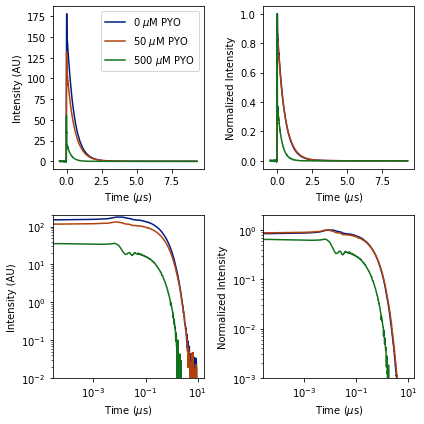

In [4]:
# Figure showing all 3 samples together pre- and post-normalization.
fig, axs = plt.subplots(figsize=(6,6), ncols=2, nrows=2)

# Plot blanked data
for ax, scale in zip(axs[:,0], 'linear,log'.split(',')):
    plt.sca(ax)
    plt.xscale(scale)
    plt.yscale(scale)
    for i, (sname, sdata) in enumerate(samples):
        plt.plot(sdata.T*1e6, sdata.Y, color=pal[i], label=sname)
        plt.ylabel('Intensity (AU)')
        plt.xlabel('Time ($\mu$s)')
    
    if scale == 'linear':
        plt.legend(loc='best')
    if scale == 'log':
        plt.ylim(1e-2,2e2)

# Plot normalized blanked data
for ax, scale in zip(axs[:,1], 'linear,log'.split(',')):
    plt.sca(ax)
    plt.xscale(scale)
    plt.yscale(scale)
    for i, (sname, sdata) in enumerate(samples):
        plt.plot(sdata.T*1e6, sdata.Ynorm, color=pal[i], label=sname)
        plt.ylabel('Normalized Intensity')
        plt.xlabel('Time ($\mu$s)')
        
    if scale == 'log':
        plt.ylim(1e-3,2e0)
    
plt.tight_layout()
plt.show()
    

N = 1; exps = [1.74619952], R2 = 0.9928448830593769
N = 2; exps = [1.96178509 1.96728691], R2 = 0.9997922362412491
Chosen fit is order 1 exponential
y = 0.859 exp(1.75 t)
N = 1; exps = [1.76903287], R2 = 0.9984044610475342
N = 2; exps = [1.85846315 1.87715546], R2 = 0.99971970219007
Chosen fit is order 1 exponential
y = 0.846 exp(1.77 t)
N = 1; exps = [3.20488823], R2 = 0.9914817203911332
N = 2; exps = [3.27082165 3.19961963], R2 = 0.9914804971664604
Chosen fit is order 1 exponential
y = 0.395 exp(3.2 t)


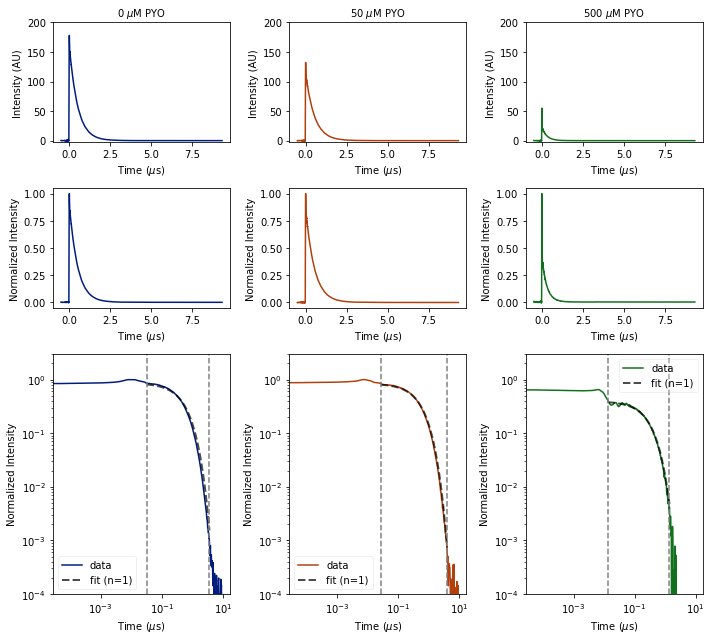

In [5]:
# Figure showing data and fitting along the columns
fig, axs = plt.subplots(figsize=(10,9), ncols=3, nrows=3, gridspec_kw=dict(height_ratios=[1,1,2]))

for i, (sname, sdata) in enumerate(samples):
    ax = axs[0,i]
    plt.sca(ax)
    
    plt.plot(sdata.T*1e6, sdata.Y, color=pal[i])
    plt.ylabel('Intensity (AU)')
    plt.ylim(-3, 200)
    
    plt.xlabel('Time ($\mu$s)')
    plt.title(sname, fontsize=10)
    
for i, (sname, sdata) in enumerate(samples):
    ax = axs[1,i]
    plt.sca(ax)
    
    plt.plot(sdata.T*1e6, sdata.Ynorm, color=pal[i])
    plt.ylabel('Normalized Intensity')    
    plt.xlabel('Time ($\mu$s)')
    
fit_exps = []
for i, (sname, sdata) in enumerate(samples):
    ax = axs[2,i]
    plt.sca(ax)
    
    # Start fitting a bit after the maximum intensity
    ys_norm = sdata.Ynorm
    start_idx = ys_norm.argmax() + 20
    tstart = sdata.T[start_idx]
    
    # Endpoint is chosen as either the end of the data or the 
    # point where a windowed std-dev exceeds 25% of the mean.
    y_series = pd.Series(ys_norm[start_idx:])
    t_series = pd.Series(sdata.T[start_idx:])
    rolling_CV = y_series.rolling(5).std()
    rolling_CV /= y_series.rolling(5).mean()
    rolling_t = t_series.rolling(5).mean()
    mask = np.abs(rolling_CV) > 0.25
    if mask.any():
        end_idx = np.where(mask)[0][0]
        tend = rolling_t[end_idx]
    else:
        end_idx = t_series.size - 1
        tend = t_series.values[-1]
    
    fitting_ts = sdata.T[start_idx:start_idx+end_idx]
    fitting_ys = ys_norm[start_idx:start_idx+end_idx]
    
    # Fit single and bi-exponentials
    fit_results, best_n = _do_fit(fitting_ts, fitting_ys)
    print('\n'.join(['N = {0}; exps = {1}, R2 = {2}'.format(n, d['exponents']*1e-6, d['r2'])
                     for n, d in fit_results.items()]))
    print('Chosen fit is order', best_n, 'exponential')
    
    # Predict from fit
    prefactors  = fit_results[best_n]['prefactors']
    exps  = fit_results[best_n]['exponents']
    fit_exps.append(np.min(exps))
    pred_ys = eval_exp_fit(fitting_ts, prefactors, exps)
    exp_strs = ['{0:.3g} exp({1:.3g} t)'.format(p,e*1e-6) for p,e in zip(prefactors, exps)]
    fit_eqn = 'y = ' + ' + '.join(exp_strs)
    print(fit_eqn)

    plt.loglog(sdata.T*1e6, ys_norm, color=pal[i], label='data')
    plt.loglog(fitting_ts*1e6, pred_ys, color='k', ls='--', alpha=0.7,
               lw=2, label='fit (n={0})'.format(best_n))
    plt.axvline(tstart*1e6, color='grey', ls='--')
    plt.axvline(tend*1e6, color='grey', ls='--')

    plt.legend(framealpha=0.3)
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Time ($\mu$s)')
    plt.ylim(1e-4, 3)
    
plt.tight_layout()
plt.show()

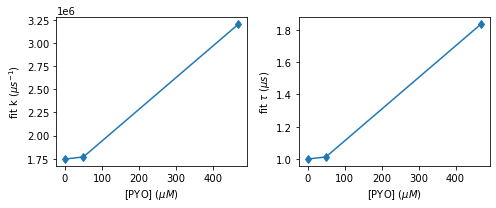

In [6]:
# nominal concentrations are not the same as actual concentrations
# because we need to account for the volume added when adding pyocyanin. 
nominal_concs_um = np.array([0, 50, 500])
ul_added = np.array([0, 13.3, 133.3])
starting_volume = 2000
stock_conc = 7.5e3
new_vols = ul_added+starting_volume
actual_concs = stock_conc*ul_added/new_vols

# little k is what we fit, which is the sum of all the microscopic rate
# constants for excited state decay. 
ks = np.array(fit_exps)
# k/k0 = tau0/tau since tau = 1/k.
taus_norm = ks/ks[0]

# Janky Stern-Volmer plot didn't come out so linear, but the fitting 
# procedure has the potential for many artifacts. 
fig, axs = plt.subplots(ncols=2, figsize=(7,3))
plt.sca(axs[0])
plt.plot(actual_concs, ks, marker='d')
plt.xlabel('[PYO] ($\mu M$)')
plt.ylabel('fit k ($\mu s^{-1}$)')

plt.sca(axs[1])
plt.plot(actual_concs, taus_norm, marker='d')
plt.xlabel('[PYO] ($\mu M$)')
plt.ylabel('fit $\\tau$ ($\mu s$)')

plt.tight_layout()
plt.show()
